In [5]:
import os
import pdb
import sys, ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
datasets_dir = os.getcwd()

def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h


def mnist(noTrSamples=1000, noTsSamples=100, digit_range=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], noTrPerClass=100, noTsPerClass=10):
    assert noTrSamples==noTrPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    assert noTsSamples==noTsPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    data_dir = os.path.join(datasets_dir, 'data')
    fd = open(os.path.join(data_dir, 'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trData = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trLabels = loaded[8:].reshape((60000)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsData = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsLabels = loaded[8:].reshape((10000)).astype(float)

    trData = trData/255.
    tsData = tsData/255.

    tsX = np.zeros((noTsSamples, 28*28))
    trX = np.zeros((noTrSamples, 28*28))
    tsY = np.zeros(noTsSamples)
    trY = np.zeros(noTrSamples)

    count = 0
    for ll in digit_range:
        # Train data
        idl = np.where(trLabels == ll)
        idl = idl[0][: noTrPerClass]
        idx = list(range(count*noTrPerClass, (count+1)*noTrPerClass))
        trX[idx, :] = trData[idl, :]
        trY[idx] = trLabels[idl]
        # Test data
        idl = np.where(tsLabels == ll)
        idl = idl[0][: noTsPerClass]
        idx = list(range(count*noTsPerClass, (count+1)*noTsPerClass))
        tsX[idx, :] = tsData[idl, :]
        tsY[idx] = tsLabels[idl]
        count += 1
    
    np.random.seed(1)
    test_idx = np.random.permutation(tsX.shape[0])
    tsX = tsX[test_idx,:]
    tsY = tsY[test_idx]

    trX = trX.T
    tsX = tsX.T
    trY = trY.reshape(1, -1)
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY

0.0

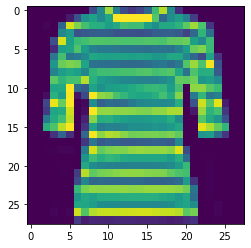

In [8]:
trX, trY, tsX, tsY = mnist(noTrSamples=30, noTsSamples=15, digit_range=[0, 5, 8], noTrPerClass=10, noTsPerClass=5)
plt.imshow(trX[:,5].reshape(28, -1))
trY[0,5]

In [9]:
# ACTIVATION FUNCTIONS, THEIR DERIVATIVES AND LOSS FUNCTIONS
def relu(Z):
    A = np.maximum(0,Z)
    cache = {}
    cache["Z"] = Z
    return A, cache

def relu_der(dA, cache):
    dZ = np.array(dA, copy=True)
    Z = cache["Z"]
    dZ[Z<0] = 0
    return dZ

def linear(Z):
    A = Z
    cache = {}
    return A, cache

def linear_der(dA, cache):
    dZ = np.array(dA, copy=True)
    return dZ

def softmax_cross_entropy_loss(Z, Y=np.array([])):
    m = Y.shape[1]
    A = np.exp(Z - np.amax(Z, axis=0)) / np.sum(np.exp(Z - np.amax(Z, axis=0)), axis=0)
    cache = {}
    cache['Z'] = Z
    loss = np.sum(-np.log(np.choose(Y.astype(np.int64), A))) / m
    return A, cache, loss


def softmax_cross_entropy_loss_der(Y, cache):
    Z = cache['Z']
    Y_one_hot = np.eye(Z.shape[0])[Y.astype(np.int64).reshape(-1)].T
    A = np.exp(Z - np.amax(Z, axis=0)) / np.sum(np.exp(Z - np.amax(Z, axis=0)), axis=0)
    dZ = A - Y_one_hot
    return dZ

In [10]:
def initialize_multilayer_weights(net_dims):
    np.random.seed(0)
    numLayers = len(net_dims)
    parameters = {}
    for l in range(numLayers - 1):
        parameters["W" + str(l + 1)] = np.random.randn(net_dims[l + 1], net_dims[l]) * 0.01
        parameters["b" + str(l + 1)] = np.random.randn(net_dims[l + 1], 1) * 0.01
    return parameters

In [11]:
# FORWARD PASS
def linear_forward(A, W, b):
    Z = np.dot(W,  A) + b
    cache = {}
    cache["A"] = A
    cache["W"] = W
    cache["b"] = b
    return Z, cache

def layer_forward(A_prev, W, b, activation):
    Z, lin_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, act_cache = relu(Z)
    elif activation == "linear":
        A, act_cache = linear(Z)
    
    cache = {}
    cache["lin_cache"] = lin_cache
    cache["act_cache"] = act_cache
    return A, cache

def multi_layer_forward(X, parameters):
    L = len(parameters)//2  
    A = X
    caches = []
    for l in range(1,L):  # since there is no W0 and b0
        A, cache = layer_forward(A, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)

    AL, cache = layer_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "linear")
    caches.append(cache)
    return AL, caches

In [12]:
def linear_backward(dZ, cache, W, b):
    A_prev = cache["A"]
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def layer_backward(dA, cache, W, b, activation):
    lin_cache = cache["lin_cache"]
    act_cache = cache["act_cache"]

    if activation == "sigmoid":
        dZ = sigmoid_der(dA, act_cache)
    elif activation == "tanh":
        dZ = tanh_der(dA, act_cache)
    elif activation == "relu":
        dZ = relu_der(dA, act_cache)
    elif activation == "linear":
        dZ = linear_der(dA, act_cache)
    dA_prev, dW, db = linear_backward(dZ, lin_cache, W, b)
    return dA_prev, dW, db

def multi_layer_backward(dAL, caches, parameters):
    L = len(caches)  # with one hidden layer, L = 2
    gradients = {}
    dA = dAL
    activation = "linear"
    for l in reversed(range(1,L+1)):
        dA, gradients["dW"+str(l)], gradients["db"+str(l)] = \
                    layer_backward(dA, caches[l-1], \
                    parameters["W"+str(l)],parameters["b"+str(l)],\
                    activation)
        activation = "relu"
    return gradients

In [13]:
def classify(X, parameters):
    A = X
    m = X.shape[1]
    numLayers = len(parameters) // 2

    for l in range(numLayers - 1):
        Z = np.dot(parameters['W' + str(l + 1)], A) + parameters['b' + str(l + 1)]
        A = np.maximum(0, Z)
    Z = np.dot(parameters['W' + str(numLayers)], A) + parameters['b' + str(numLayers)]
    A = np.exp(Z - np.amax(Z, axis=0)) / np.sum(np.exp(Z - np.amax(Z, axis=0)), axis=0)
    return np.argmax(A, axis=0)
    return Ypred

In [14]:
def plot_cost(costs, layer, train, test):
    ax = plt.subplot()
    ax.plot([i for i in range(0,len(costs)*10,10)],costs,marker ='o',ms="2",markeredgecolor="r")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Training Error")
    ax.set_title("Deep Multi Class Classifier "+str(layer)+" Hidden Layer Network")
    plt.text(200, 2.0, "Train Acc = " + str(train))
    plt.text(200, 1.75, "Test Acc = " + str(test))
    plt.show()

In [15]:
# UPDATE FUNCTIONS
def update_parameters_no_momentum(parameters, gradients, epoch, learning_rate, decay_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]
    learning_rate = learning_rate * (1 / ( 1 + decay_rate * epoch))
    return parameters, learning_rate


def update_parameters_momentum(parameters, gradients, epoch, learning_rate, velocity, gamma=0.9):
    L = len(parameters)//2
    for l in range(L):
        k = "VW" + str(l + 1)
        if(k in velocity.keys()):
#             print(type(velocity["VW" + str(l + 1)]))
            velocity["VW" + str(l + 1)] = gamma * velocity["VW" + str(l + 1)] + learning_rate * gradients["dW" + str(l + 1)]
        else:
            velocity["VW" + str(l + 1)] = learning_rate * gradients["dW" + str(l + 1)]
        
        k = "Vb" + str(l + 1)
        if(k in velocity.keys()):
            velocity["Vb" + str(l + 1)] = gamma * velocity["Vb" + str(l + 1)] + learning_rate * gradients["db" + str(l + 1)]
        else:
            velocity["Vb" + str(l + 1)] = learning_rate * gradients["db" + str(l + 1)]
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - velocity["VW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - velocity["Vb" + str(l + 1)]
    return parameters, velocity


def update_parameters_rms_prop(parameters, gradients, epoch, learning_rate, decay_rate, velocity):
    L = len(parameters)//2
#     print(velocity.keys())
    for l in range(L):
        k = "VW" + str(l + 1)
        if(k in velocity.keys()):
            velocity["VW" + str(l + 1)] = decay_rate * velocity["VW" + str(l + 1)] + (1.0 - decay_rate) * (gradients["dW" + str(l + 1)] ** 2)
        else:
            velocity["VW" + str(l + 1)] = (1.0 - decay_rate) * (gradients["dW" + str(l + 1)] ** 2)
        
        k = "Vb" + str(l + 1)
        if(k in velocity.keys()):
            velocity["Vb" + str(l + 1)] = decay_rate * velocity["Vb" + str(l + 1)] + (1.0 - decay_rate) * (gradients["db" + str(l + 1)] ** 2)
        else:
            velocity["Vb" + str(l + 1)] = (1.0 - decay_rate) * (gradients["db" + str(l + 1)] ** 2)
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * gradients["dW" + str(l + 1)]) / np.sqrt(velocity["VW" + str(l + 1)] + 1e-7)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * gradients["db" + str(l + 1)]) / np.sqrt(velocity["Vb" + str(l + 1)] + 1e-7)
    return parameters, velocity, learning_rate




def update_parameters_adam(parameters, gradients, epoch, learning_rate, velocity):
    beta1 = 0.9
    beta2 = 0.999
    L = len(parameters)//2
    for l in range(L):
        k = "VFW" + str(l + 1)
        if(k in velocity.keys()):
            velocity["VFW" + str(l + 1)] = beta1 * velocity["VFW" + str(l + 1)] + (1.0 - beta1) * gradients["dW" + str(l + 1)]
        else:
            velocity["VFW" + str(l + 1)] = (1.0 - beta1) * gradients["dW" + str(l + 1)]
            
        k = "VFb" + str(l + 1)
        if(k in velocity.keys()):
            velocity["VFb" + str(l + 1)] = beta1 * velocity["VFb" + str(l + 1)] + (1.0 - beta1) * gradients["db" + str(l + 1)]
        else:
            velocity["VFb" + str(l + 1)] = (1.0 - beta1) * gradients["db" + str(l + 1)]
        
        k = "VSW" + str(l + 1)
        if(k in velocity.keys()):
            velocity["VSW" + str(l + 1)] = beta2 * velocity["VSW" + str(l + 1)] + (1.0 - beta2) * (gradients["dW" + str(l + 1)] ** 2)
        else:
            velocity["VSW" + str(l + 1)] = (1.0 - beta2) * (gradients["dW" + str(l + 1)] ** 2)
            
        k = "VSb" + str(l + 1)
        if(k in velocity.keys()):
            velocity["SFb" + str(l + 1)] = beta2 * velocity["VSb" + str(l + 1)] + (1.0 - beta2) * (gradients["db" + str(l + 1)] ** 2)
        else:
            velocity["VSb" + str(l + 1)] = (1.0 - beta2) * (gradients["db" + str(l + 1)] ** 2)
        
        first_unbias = {}
        second_unbias = {}
        first_unbias["W" + str(l + 1)] = velocity["VFW" + str(l + 1)] / (1.0 - (beta1 ** (epoch + 1)))
        first_unbias["b" + str(l + 1)] = velocity["VFb" + str(l + 1)] / (1.0 - (beta1 ** (epoch + 1)))
        
        second_unbias["W" + str(l + 1)] = velocity["VSW" + str(l + 1)] / (1.0 - (beta2 ** (epoch + 1)))
        second_unbias["b" + str(l + 1)] = velocity["VSb" + str(l + 1)] / (1.0 - (beta2 ** (epoch + 1)))
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * first_unbias["W" + str(l + 1)]) / (np.sqrt(second_unbias["W" + str(l + 1)]) + 1e-8)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * first_unbias["b" + str(l + 1)]) / (np.sqrt(second_unbias["b" + str(l + 1)]) + 1e-8)
    return parameters, velocity

def update_parameters_adagrad(parameters, gradients, epoch, learning_rate, velocity):
    L = len(parameters)//2
    for l in range(L):
        k = "W" + str(l + 1)
        if(k in velocity.keys()):
            velocity["W" + str(l + 1)] = velocity["W" + str(l + 1)] + (gradients["dW" + str(l + 1)] ** 2)
        else:
            velocity["W" + str(l + 1)] = (gradients["dW" + str(l + 1)] ** 2)
        
        k = "b" + str(l + 1)
        if(k in velocity.keys()):
            velocity["b" + str(l + 1)] = velocity["b" + str(l + 1)] + (gradients["db" + str(l + 1)] ** 2)
        else:
            velocity["b" + str(l + 1)] = (gradients["db" + str(l + 1)] ** 2)

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * gradients["dW" + str(l + 1)] / (np.sqrt(velocity["W" + str(l + 1)]) + 1e-7))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * gradients["db" + str(l + 1)] / (np.sqrt(velocity["b" + str(l + 1)]) + 1e-7))
    return parameters, velocity

def update_parameters_adadelta(parameters, gradients, epoch, learning_rate, velocity):
    gamma = 0.9
    L = len(parameters)//2
    for l in range(L):
        k = "W" + str(l + 1)
        if(k in velocity.keys()):
            velocity["W" + str(l + 1)] = gamma * velocity["W" + str(l + 1)] + (1.0 - gamma) * (gradients["dW" + str(l + 1)] ** 2)
        else:
            velocity["W" + str(l + 1)] = (1.0 - gamma) * (gradients["dW" + str(l + 1)] ** 2)
        
        k = "b" + str(l + 1)
        if(k in velocity.keys()):
            velocity["b" + str(l + 1)] = gamma * velocity["b" + str(l + 1)] + (1.0 - gamma) * (gradients["db" + str(l + 1)] ** 2)
        else:
            velocity["b" + str(l + 1)] = (1.0 - gamma) * (gradients["db" + str(l + 1)] ** 2)

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * gradients["dW" + str(l + 1)] / (np.sqrt(velocity["W" + str(l + 1)]) + 1e-7))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * gradients["db" + str(l + 1)] / (np.sqrt(velocity["b" + str(l + 1)]) + 1e-7))
    return parameters, velocity


In [16]:
def multi_layer_network(X, Y, X_val, Y_val, net_dims, num_iterations=500, learning_rate=0.2, decay_rate=0.0, updation_param='NoMomentum', velocity={}):
    parameters = initialize_multilayer_weights(net_dims)
    A0 = X
    A0_val = X_val
    costs_train = []
    costs_val = []
    for ii in range(num_iterations):
        
        # Forward Prop
        
        ## call to multi_layer_forward to get activations
        A1, cache1 = multi_layer_forward(A0, parameters)
        ## call to softmax cross entropy loss
        A2, cache2, cost_train = softmax_cross_entropy_loss(A1,Y)

        ## call to multi_layer_forward to get activations
        A1_val, cache1_val = multi_layer_forward(A0_val, parameters)
        ## call to softmax cross entropy loss
        A2_val, cache2_val, cost_val = softmax_cross_entropy_loss(A1_val,Y_val)

        # Backward Prop
        ## call to softmax cross entropy loss der
        dZ = softmax_cross_entropy_loss_der(Y, cache2)
        ## call to multi_layer_backward to get gradients
        gradients = multi_layer_backward(dZ, cache1, parameters)
        ## call to update the parameters
        
        if(updation_param == "NoMomentum"):
            parameters, learning_rate = update_parameters_no_momentum(parameters, gradients, ii, learning_rate, decay_rate)
        
        elif(updation_param == "Momentum"):
            parameters, velocity = update_parameters_momentum(parameters, gradients, ii, learning_rate, velocity)
        
#         elif(updation_param == "Nestrov"):
#             parameters, learning_rate = update_parameters_no_momentum(parameters, gradients, ii, learning_rate, decay_rate)
        
        elif(updation_param == "RMSProp"):
            parameters, velocity, learning_rate = update_parameters_rms_prop(parameters, gradients, ii, learning_rate, decay_rate, velocity)
        
        elif(updation_param == "Adam"):
            parameters, velocity = update_parameters_adam(parameters, gradients, ii, learning_rate, velocity)
        
        elif(updation_param == "AdaGrad"):
            parameters, velocity = update_parameters_adagrad(parameters, gradients, ii, learning_rate, velocity)
        
        elif(updation_param == "AdaDelta"):
            parameters, velocity = update_parameters_adadelta(parameters, gradients, ii, learning_rate, velocity)
        
        
        # if ii % 10 == 0:
        #     costs.append(cost)
        costs_train.append(cost_train)
        costs_val.append(cost_val)
        if ii % 100 == 0:
            print("Cost at iteration %i is: %.05f, %.05f, learning rate: %.05f" %(ii, cost_train, cost_val, learning_rate))
    
    return costs_train, costs_val , parameters

In [17]:
num_hidden_1 = 500
num_hidden_2 = 100
net_dims = [784, num_hidden_1, num_hidden_2]
net_dims.append(10) # Adding the digits layer with dimensionality = 10
print("Network dimensions are:" + str(net_dims))

# getting the subset dataset from MNIST
train_val_data, train_val_label, test_data, test_label = mnist(noTrSamples=6000, noTsSamples=1000, digit_range=[0,1,2,3,4,5,6,7,8,9], noTrPerClass=600, noTsPerClass=100)

train_data, val_data, train_label, val_label = train_test_split(train_val_data.T, train_val_label.T, test_size=1000, random_state=42)
train_data = train_data.T
val_data = val_data.T
train_label = train_label.T 
val_label = val_label.T

# initialize learning rate and num_iterations
# learning_rate = [0.1, 0.5, 1, 10]
lr = 0.01
num_iterations = 1000


Network dimensions are:[784, 500, 100, 10]


Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 0.62270, 0.63438, learning rate: 0.01000
Cost at iteration 200 is: 0.55812, 0.66429, learning rate: 0.01000
Cost at iteration 300 is: 0.57450, 0.68902, learning rate: 0.01000
Cost at iteration 400 is: 0.26300, 0.45974, learning rate: 0.01000
Cost at iteration 500 is: 0.24105, 0.53181, learning rate: 0.01000
Cost at iteration 600 is: 0.38135, 0.70573, learning rate: 0.01000
Cost at iteration 700 is: 0.09342, 0.55261, learning rate: 0.01000
Cost at iteration 800 is: 0.07252, 0.60247, learning rate: 0.01000
Cost at iteration 900 is: 0.04764, 0.72042, learning rate: 0.01000
Accuracy for training set is 97.820 %
Accuracy for validation set is 85.700 %
Accuracy for testing set is 84.700 %
Final Cost for training set is 0.060
Final Cost for validation set is 0.850


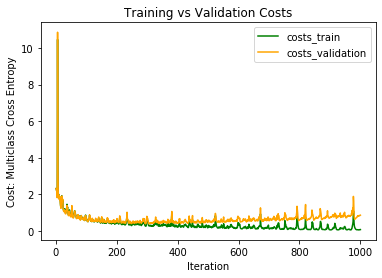

In [19]:
# RMS Prop
costs_train_rms_prop, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, decay_rate=0.9, updation_param="RMSProp")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_rms_prop[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_rms_prop, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 2.30145, 2.30133, learning rate: 0.00975
Cost at iteration 200 is: 2.30023, 2.30037, learning rate: 0.00904
Cost at iteration 300 is: 2.29873, 2.29909, learning rate: 0.00798
Cost at iteration 400 is: 2.29692, 2.29743, learning rate: 0.00670
Cost at iteration 500 is: 2.29481, 2.29543, learning rate: 0.00535
Cost at iteration 600 is: 2.29256, 2.29324, learning rate: 0.00406
Cost at iteration 700 is: 2.29039, 2.29110, learning rate: 0.00294
Cost at iteration 800 is: 2.28850, 2.28923, learning rate: 0.00202
Cost at iteration 900 is: 2.28703, 2.28777, learning rate: 0.00132
Accuracy for training set is 13.540 %
Accuracy for validation set is 11.700 %
Accuracy for testing set is 13.900 %
Final Cost for training set is 2.286
Final Cost for validation set is 2.287


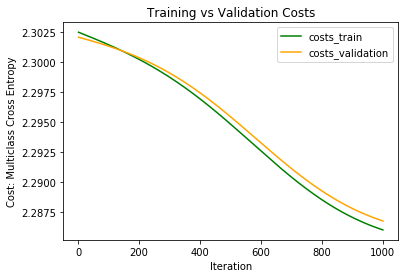

In [20]:
# No Momentum
costs_train_no_momentum, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, decay_rate=0.000005, updation_param="NoMomentum")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_no_momentum[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_no_momentum, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 2.24949, 2.25002, learning rate: 0.01000
Cost at iteration 200 is: 1.12850, 1.09011, learning rate: 0.01000
Cost at iteration 300 is: 0.84684, 0.79707, learning rate: 0.01000
Cost at iteration 400 is: 0.73782, 0.69868, learning rate: 0.01000
Cost at iteration 500 is: 0.63709, 0.61902, learning rate: 0.01000
Cost at iteration 600 is: 0.57020, 0.57143, learning rate: 0.01000
Cost at iteration 700 is: 0.52452, 0.53981, learning rate: 0.01000
Cost at iteration 800 is: 0.48724, 0.51570, learning rate: 0.01000
Cost at iteration 900 is: 0.45398, 0.49641, learning rate: 0.01000
Accuracy for training set is 85.380 %
Accuracy for validation set is 83.500 %
Accuracy for testing set is 82.800 %
Final Cost for training set is 0.424
Final Cost for validation set is 0.481


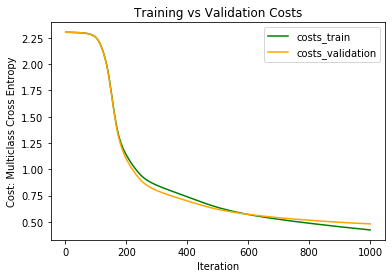

In [21]:
# Momentum
costs_train_momentum, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, updation_param="Momentum")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_momentum[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_momentum, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 0.43554, 0.47397, learning rate: 0.01000
Cost at iteration 200 is: 0.75373, 0.76985, learning rate: 0.01000
Cost at iteration 300 is: 0.31781, 0.44599, learning rate: 0.01000
Cost at iteration 400 is: 0.20299, 0.44421, learning rate: 0.01000
Cost at iteration 500 is: 0.54793, 0.54502, learning rate: 0.01000
Cost at iteration 600 is: 0.33008, 0.44990, learning rate: 0.01000
Cost at iteration 700 is: 0.27825, 0.48071, learning rate: 0.01000
Cost at iteration 800 is: 0.31975, 0.44557, learning rate: 0.01000
Cost at iteration 900 is: 0.39907, 0.63101, learning rate: 0.01000
Accuracy for training set is 86.720 %
Accuracy for validation set is 83.400 %
Accuracy for testing set is 81.800 %
Final Cost for training set is 0.363
Final Cost for validation set is 0.468


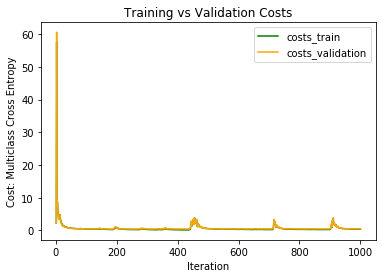

In [22]:
# Adam
costs_train_adam, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, decay_rate=0.9, updation_param="Adam")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_adam[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_adam, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 0.51453, 0.53077, learning rate: 0.01000
Cost at iteration 200 is: 0.38078, 0.43924, learning rate: 0.01000
Cost at iteration 300 is: 0.32173, 0.40042, learning rate: 0.01000
Cost at iteration 400 is: 0.26621, 0.38566, learning rate: 0.01000
Cost at iteration 500 is: 0.23607, 0.40555, learning rate: 0.01000
Cost at iteration 600 is: 0.19953, 0.39754, learning rate: 0.01000
Cost at iteration 700 is: 0.16398, 0.38555, learning rate: 0.01000
Cost at iteration 800 is: 0.14081, 0.38678, learning rate: 0.01000
Cost at iteration 900 is: 0.12457, 0.39143, learning rate: 0.01000
Accuracy for training set is 97.360 %
Accuracy for validation set is 85.900 %
Accuracy for testing set is 84.800 %
Final Cost for training set is 0.103
Final Cost for validation set is 0.418


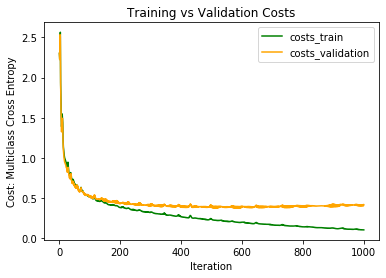

In [23]:
# AdaGrad
costs_train_adagrad, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, decay_rate=0.9, updation_param="AdaGrad")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_adagrad[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_adagrad, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

Cost at iteration 0 is: 2.30251, 2.30209, learning rate: 0.01000
Cost at iteration 100 is: 0.88269, 0.91766, learning rate: 0.01000
Cost at iteration 200 is: 0.47922, 0.56991, learning rate: 0.01000
Cost at iteration 300 is: 0.30201, 0.53414, learning rate: 0.01000
Cost at iteration 400 is: 0.25833, 0.62070, learning rate: 0.01000
Cost at iteration 500 is: 0.14403, 0.57246, learning rate: 0.01000
Cost at iteration 600 is: 0.08322, 0.74973, learning rate: 0.01000
Cost at iteration 700 is: 0.06567, 0.84101, learning rate: 0.01000
Cost at iteration 800 is: 0.38445, 1.09132, learning rate: 0.01000
Cost at iteration 900 is: 0.05529, 0.86311, learning rate: 0.01000
Accuracy for training set is 98.940 %
Accuracy for validation set is 87.000 %
Accuracy for testing set is 85.700 %
Final Cost for training set is 0.037
Final Cost for validation set is 0.906


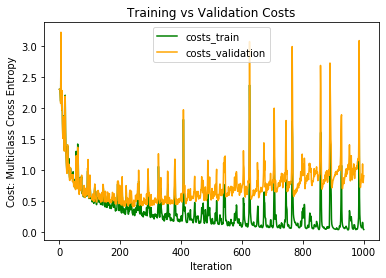

In [24]:
# AdaDelta
costs_train_adadelta, costs_val, parameters = multi_layer_network(train_data, train_label, val_data, val_label, net_dims, num_iterations=num_iterations, learning_rate=lr, decay_rate=0.9, updation_param="AdaDelta")

# compute the accuracy for training set and testing set
train_pred = classify(train_data, parameters)
val_pred = classify(val_data, parameters)
test_pred = classify(test_data, parameters)

trAcc = 100 * np.sum(train_pred== train_label)/train_label.shape[1]
valAcc = 100 * np.sum(val_pred== val_label)/val_label.shape[1]
teAcc = 100 * np.sum(test_pred == test_label)/test_label.shape[1]
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for validation set is {0:0.3f} %".format(valAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))
print("Final Cost for training set is {0:0.3f}".format(costs_train_adadelta[-1]))
print("Final Cost for validation set is {0:0.3f}".format(costs_val[-1]))

plt.plot(range(1, num_iterations + 1), costs_train_adadelta, color='g')
plt.plot(range(1, num_iterations + 1), costs_val,color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training vs Validation Costs')
plt.gca().legend(('costs_train', 'costs_validation'))
plt.show()

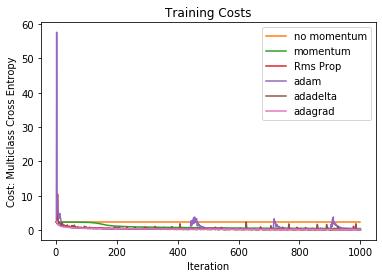

In [25]:
plt.plot(range(1, num_iterations + 1), costs_train_no_momentum, color='C1',label="no_momentum")
plt.plot(range(1, num_iterations + 1), costs_train_momentum, color='C2',label="momentum")
plt.plot(range(1, num_iterations + 1), costs_train_rms_prop, color='C3',label="rms_prop")
plt.plot(range(1, num_iterations + 1), costs_train_adam, color='C4',label="adam")
plt.plot(range(1, num_iterations + 1), costs_train_adadelta, color='C5',label="adadelta")
plt.plot(range(1, num_iterations + 1), costs_train_adagrad, color='C6',label = "adagrad")
# plt.plot(range(1, num_iterations + 1), costs_val,color='orange')

plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training Costs')
plt.gca().legend(("no momentum","momentum","Rms Prop","adam","adadelta","adagrad"))
plt.savefig("all_lr_+str(lr)+_500_100.png")
plt.show()

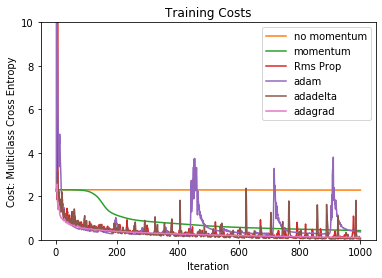

In [26]:
plt.plot(range(1, num_iterations + 1), costs_train_no_momentum, color='C1',label="no_momentum")
plt.plot(range(1, num_iterations + 1), costs_train_momentum, color='C2',label="momentum")
plt.plot(range(1, num_iterations + 1), costs_train_rms_prop, color='C3',label="rms_prop")
plt.plot(range(1, num_iterations + 1), costs_train_adam, color='C4',label="adam")
plt.plot(range(1, num_iterations + 1), costs_train_adadelta, color='C5',label="adadelta")
plt.plot(range(1, num_iterations + 1), costs_train_adagrad, color='C6',label = "adagrad")

x = np.arange(0.0,60.0)
plt.ylim(top=10)
plt.ylim(bottom=0)
# plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Cost: Multiclass Cross Entropy')
plt.title('Training Costs')
plt.gca().legend(("no momentum","momentum","Rms Prop","adam","adadelta","adagrad"))
plt.savefig("test.png",dpi=500)
plt.show()